# Classifying 1984 US House of Representatives Voting Records by Party Affiliation

## Information

Downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/seeds) on 13 November 2016. The dataset description is as follows:

- Data Set: Multivariate
- Attribute: Real
- Tasks: Classification
- Instances: 435
- Attributes: 16
- Missing Values: Yes
- Area: Social
- Date Donated: 1987-04-27

### Data Set Information:

This data set includes votes for each of the U.S. House of Representatives Congressmen on the 16 key votes identified by the CQA. The CQA lists nine different types of votes: voted for, paired for, and announced for (these three simplified to yea), voted against, paired against, and announced against (these three simplified to nay), voted present, voted present to avoid conflict of interest, and did not vote or otherwise make a position known (these three simplified to an unknown disposition).

### Attribute Information:

1. Class Name: 2 (democrat, republican)
2. handicapped-infants: 2 (y,n)
3. water-project-cost-sharing: 2 (y,n)
4. adoption-of-the-budget-resolution: 2 (y,n)
5. physician-fee-freeze: 2 (y,n)
6. el-salvador-aid: 2 (y,n)
7. religious-groups-in-schools: 2 (y,n)
8. anti-satellite-test-ban: 2 (y,n)
9. aid-to-nicaraguan-contras: 2 (y,n)
10. mx-missile: 2 (y,n)
11. immigration: 2 (y,n)
12. synfuels-corporation-cutback: 2 (y,n)
13. education-spending: 2 (y,n)
14. superfund-right-to-sue: 2 (y,n)
15. crime: 2 (y,n)
16. duty-free-exports: 2 (y,n)
17. export-administration-act-south-africa: 2 (y,n)

### Relevant Papers:

Schlimmer, J. C. (1987). Concept acquisition through representational adjustment. Doctoral dissertation, Department of Information and Computer Science, University of California, Irvine, CA.

## Python Package(s) Used

In [1]:
import dill
import json
import numpy as np
import os
import pandas as pd
import requests
import time

In [2]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates, radviz
import seaborn as sns

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix 
from sklearn.preprocessing import LabelEncoder

In [4]:
%matplotlib inline

## Data Fetching

In [5]:
# Importing data from web
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"

def fetch_data(fname='house-votes-84.data'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [6]:
FEATURES  = [
    "class_name",
    "handicapped_infants",
    "water_project_cost_sharing",
    "adoption_of_the_budget_resolution",
    "physician_fee_freeze",
    "el_salvador_aid",
    "religious_groups_in_schools",
    "anti_satellite_test_ban",
    "aid_to_nicaraguan_contras",
    "mx_missile",
    "immigration",
    "synfuels_corporation_cutback",
    "education_spending",
    "superfund_right_to_sue",
    "crime",
    "duty_free_exports",
    "export_administration_act_south_africa"
]

In [7]:
# Read the data into a DataFrame
df = pd.read_csv(DATA, sep=',', header=None, names=FEATURES)

## Data Exploration 

In [8]:
df.head()

,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [9]:
# Describe the dataset
print(df.describe())

       class_name handicapped_infants water_project_cost_sharing  \
count         435                 435                        435   
unique          2                   3                          3   
top      democrat                   n                          y   
freq          267                 236                        195   

       adoption_of_the_budget_resolution physician_fee_freeze el_salvador_aid  \
count                                435                  435             435   
unique                                 3                    3               3   
top                                    y                    n               y   
freq                                 253                  247             212   

       religious_groups_in_schools anti_satellite_test_ban  \
count                          435                     435   
unique                           3                       3   
top                              y                       y   
freq 

In [10]:
# Unique value counts for each column
for i in df.columns:
    print(df[i].value_counts())

democrat      267
republican    168
Name: class_name, dtype: int64
n    236
y    187
?     12
Name: handicapped_infants, dtype: int64
y    195
n    192
?     48
Name: water_project_cost_sharing, dtype: int64
y    253
n    171
?     11
Name: adoption_of_the_budget_resolution, dtype: int64
n    247
y    177
?     11
Name: physician_fee_freeze, dtype: int64
y    212
n    208
?     15
Name: el_salvador_aid, dtype: int64
y    272
n    152
?     11
Name: religious_groups_in_schools, dtype: int64
y    239
n    182
?     14
Name: anti_satellite_test_ban, dtype: int64
y    242
n    178
?     15
Name: aid_to_nicaraguan_contras, dtype: int64
y    207
n    206
?     22
Name: mx_missile, dtype: int64
y    216
n    212
?      7
Name: immigration, dtype: int64
n    264
y    150
?     21
Name: synfuels_corporation_cutback, dtype: int64
n    233
y    171
?     31
Name: education_spending, dtype: int64
y    209
n    201
?     25
Name: superfund_right_to_sue, dtype: int64
y    248
n    170
?     17
Name:

In [11]:
# Dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
class_name                                435 non-null object
handicapped_infants                       435 non-null object
water_project_cost_sharing                435 non-null object
adoption_of_the_budget_resolution         435 non-null object
physician_fee_freeze                      435 non-null object
el_salvador_aid                           435 non-null object
religious_groups_in_schools               435 non-null object
anti_satellite_test_ban                   435 non-null object
aid_to_nicaraguan_contras                 435 non-null object
mx_missile                                435 non-null object
immigration                               435 non-null object
synfuels_corporation_cutback              435 non-null object
education_spending                        435 non-null object
superfund_right_to_sue                    435 non-null object
crime                      

In [12]:
# Check for missing values
print(df.isnull().sum())

class_name                                0
handicapped_infants                       0
water_project_cost_sharing                0
adoption_of_the_budget_resolution         0
physician_fee_freeze                      0
el_salvador_aid                           0
religious_groups_in_schools               0
anti_satellite_test_ban                   0
aid_to_nicaraguan_contras                 0
mx_missile                                0
immigration                               0
synfuels_corporation_cutback              0
education_spending                        0
superfund_right_to_sue                    0
crime                                     0
duty_free_exports                         0
export_administration_act_south_africa    0
dtype: int64


In [13]:
df_2 = df.copy()

In [14]:
# Labelencoding
df_2['class_name'] = df_2['class_name'].map({'democrat':0,'republican':1})

for i in df_2.columns[1:]:
    df_2[i] = df_2[i].map({'n': 0,'y': 1,'?':2})

In [15]:
df_2.head()

,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,1,0,1,0,1,1,1,0,0,0,1,2,1,1,1,0,1
1,1,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,2
2,0,2,1,1,2,1,1,0,0,0,0,1,0,1,1,0,0
3,0,0,1,1,0,2,1,0,0,0,0,1,0,1,0,0,1
4,0,1,1,1,0,1,1,0,0,0,0,1,2,1,1,1,1


class_name


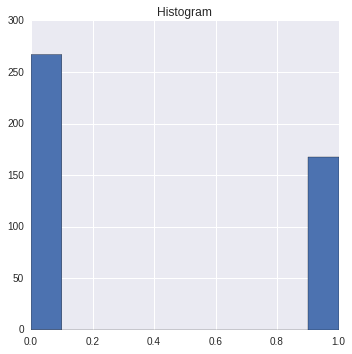

handicapped_infants


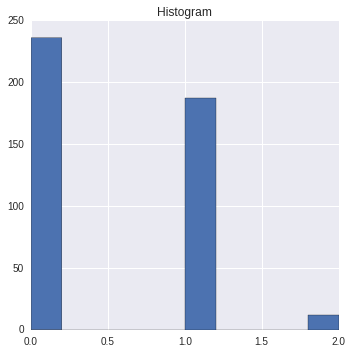

water_project_cost_sharing


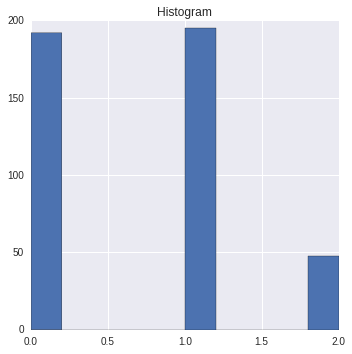

adoption_of_the_budget_resolution


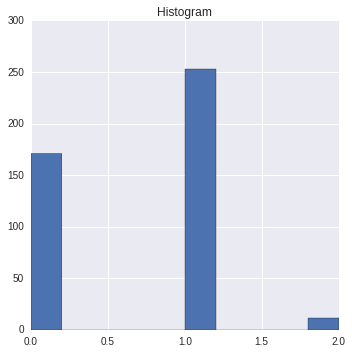

physician_fee_freeze


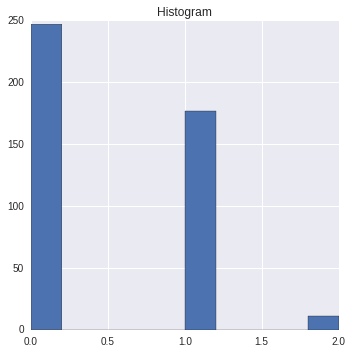

el_salvador_aid


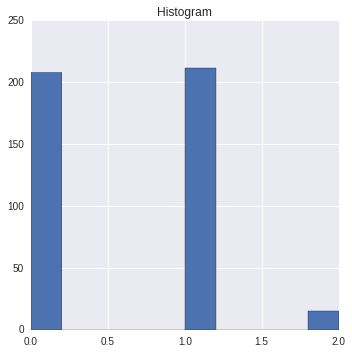

religious_groups_in_schools


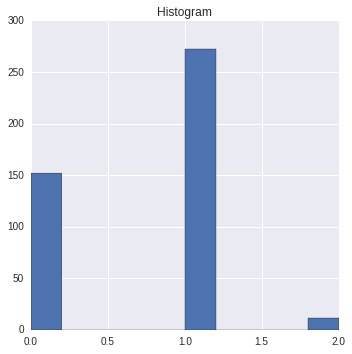

anti_satellite_test_ban


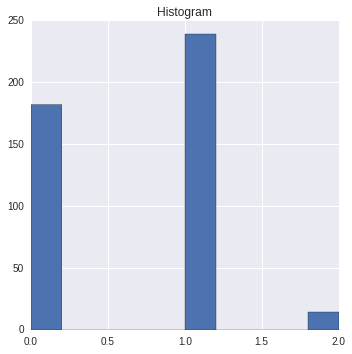

aid_to_nicaraguan_contras


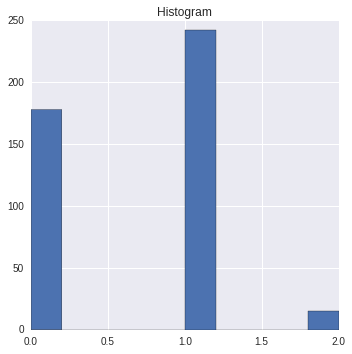

mx_missile


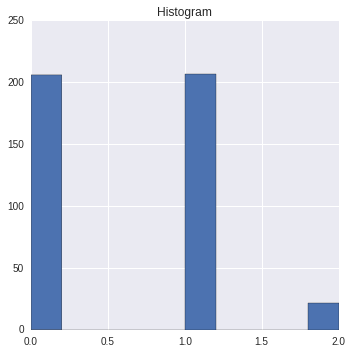

immigration


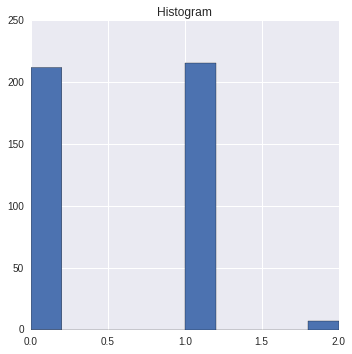

synfuels_corporation_cutback


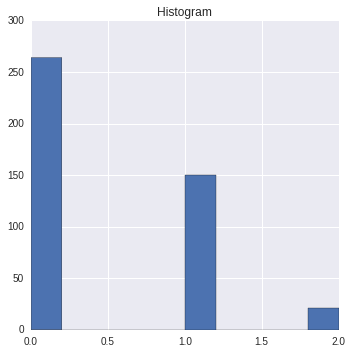

education_spending


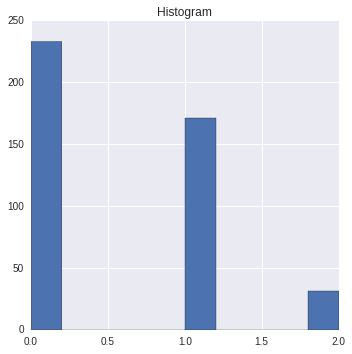

superfund_right_to_sue


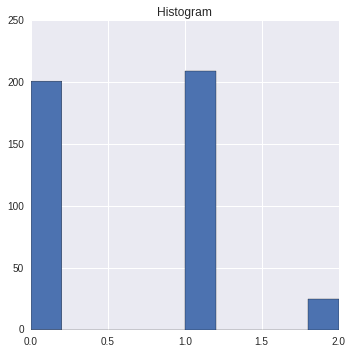

crime


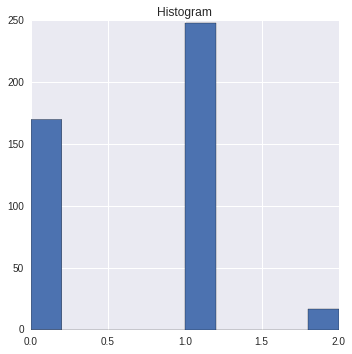

duty_free_exports


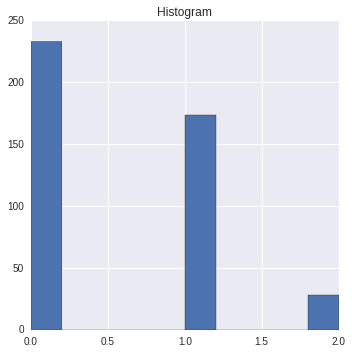

export_administration_act_south_africa


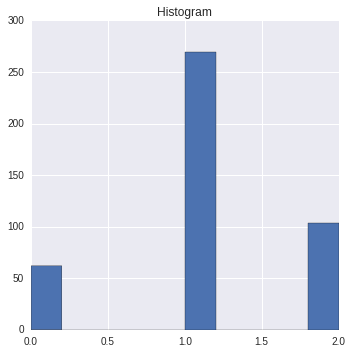

In [16]:
# First pass for looking at frequency counts as a function of column.

for i in df_2.iloc[:,:]:
    print(i) 
   
    plt.figure(1, figsize = (5,5), dpi = 80)
    #histogram plot
    plt.subplot(111)
    plt.title("Histogram")
    plt.hist(df_2.iloc[:,:][i])    
    
    plt.tight_layout()
    plt.show()

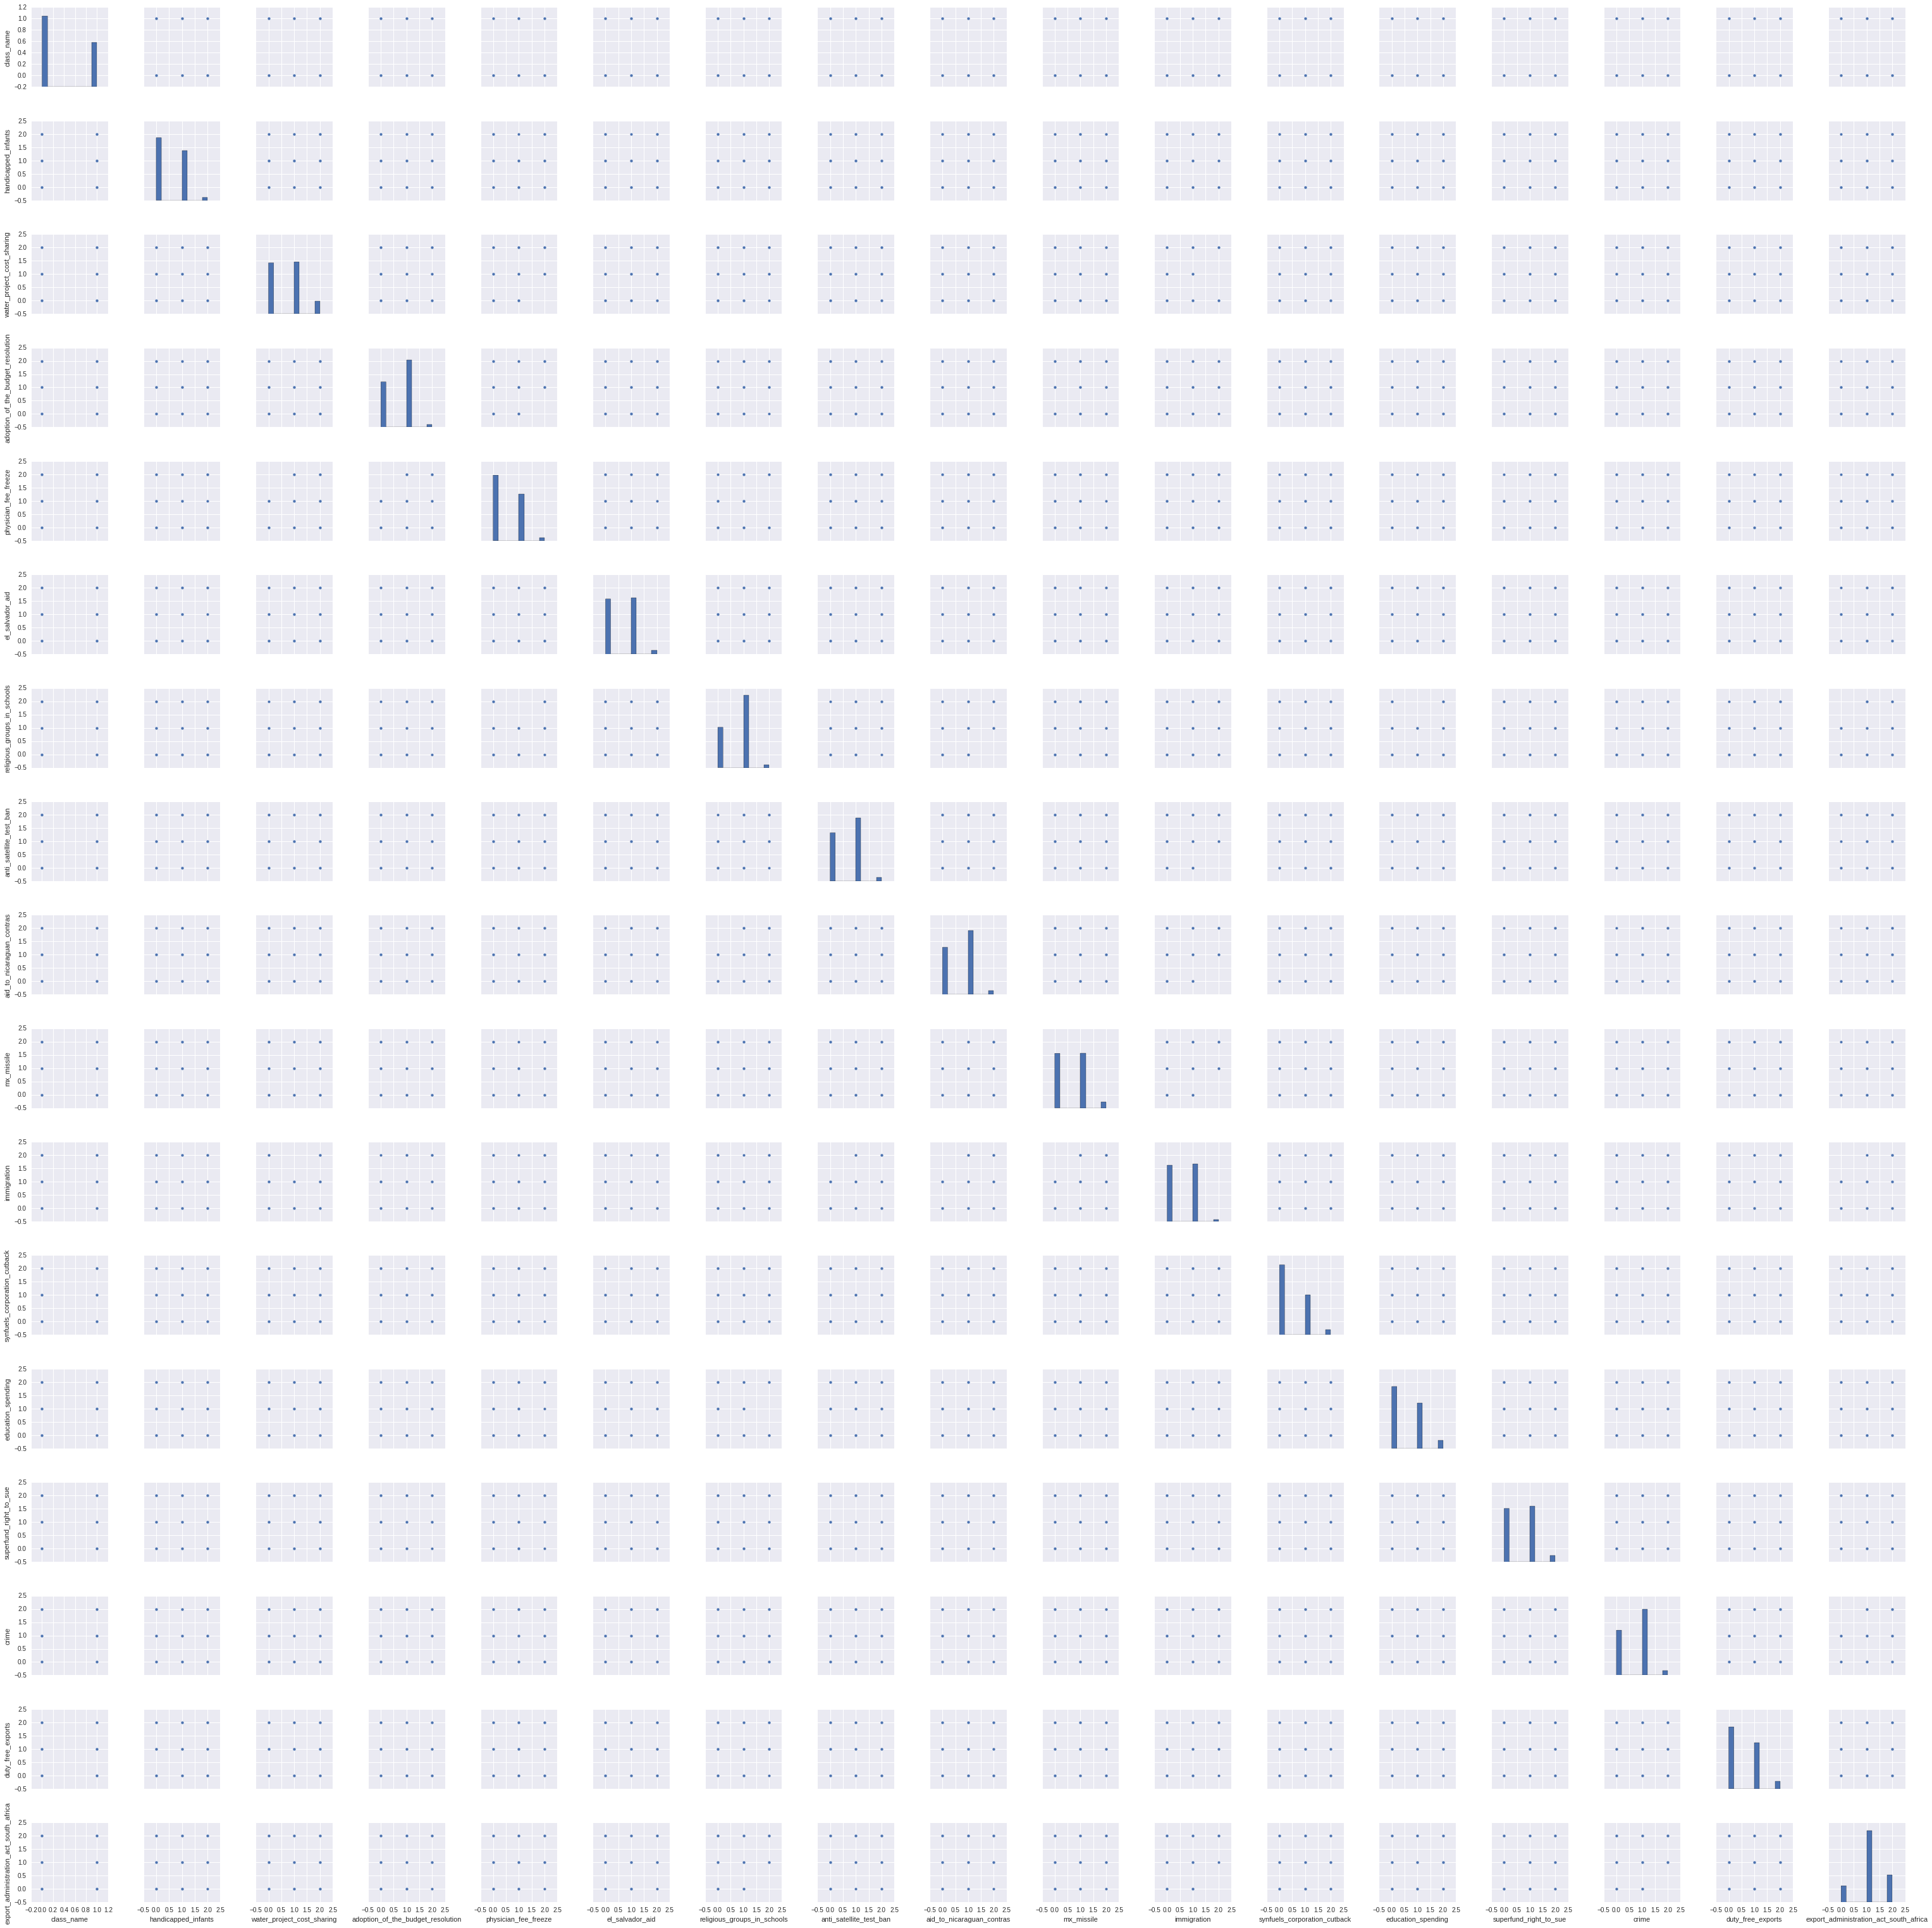

In [17]:
# Pairplot
sns.pairplot(df_2)

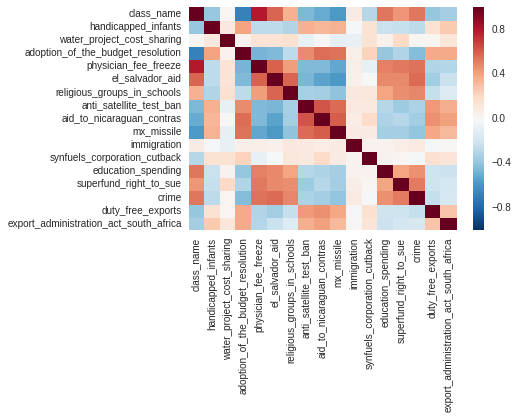

In [18]:
# Correlation heatmap
sns.heatmap(df_2.corr())

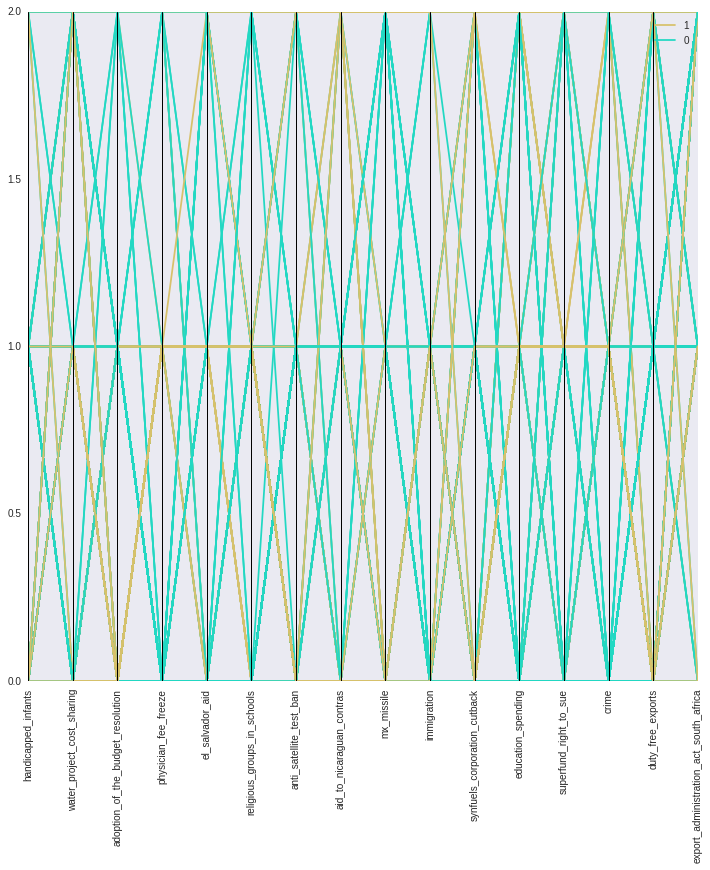

In [19]:
# Parallel coordinates plot
plt.figure(figsize=(12,12))
plt.xticks(rotation='vertical')
parallel_coordinates(df_2, 'class_name')
plt.show()

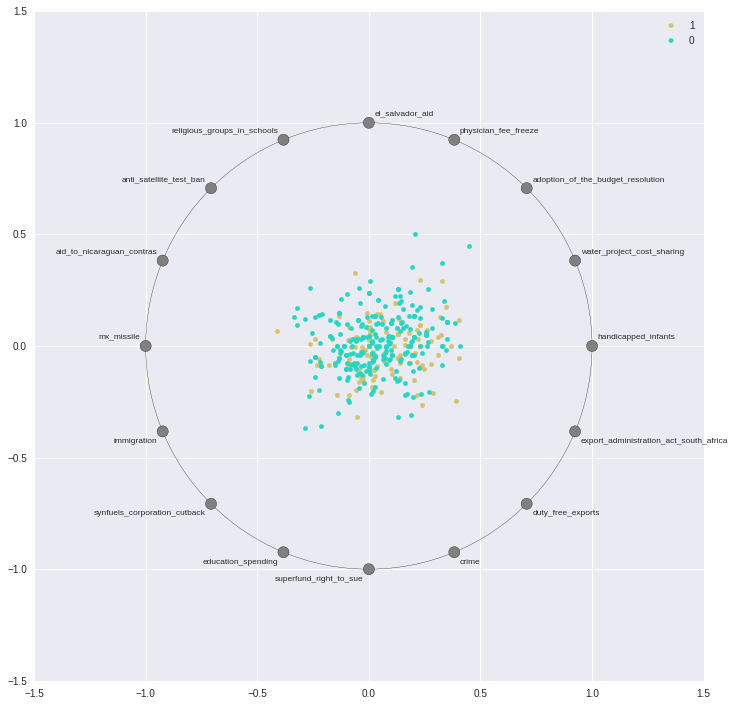

In [20]:
# Radial plot
plt.figure(figsize=(12,12))
radviz(df_2, 'class_name')
plt.show()

## Data Extraction 

Keeping Bunches method for later use.

## Logistic Regression Classification

In [21]:
df_3 = df_2.copy()
# Drop target column for test-train-split
df_3 = df_3.drop('class_name', axis=1)

In [22]:
# Test-train split. Learning curves not performed. Using 80/20% split.
X_train, X_test, y_train, y_test = train_test_split(df_3, df_2['class_name'], train_size=0.8,
                                                    random_state=1)

In [23]:
# Data not scaled, since total range of data is 0-2 and categorical.
clf = LogisticRegression()

In [24]:
# Initialize RFECV for feature selection
rfecv = RFECV(estimator=clf, step=1, cv=12, scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 5


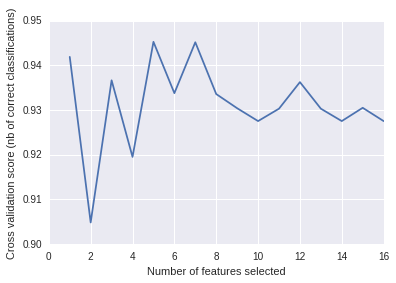

In [25]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [26]:
# Print out table of sorted features by importance. Top features become the features used for ML.
print("Features sorted: ")
rfecv_ranking_df = pd.DataFrame({'feature':X_train.columns,
                                     'importance':rfecv.ranking_})
rfecv_ranking_df_sorted = rfecv_ranking_df.sort_values(by = 'importance'
                                        , ascending = True)
rfecv_ranking_df_sorted

Features sorted: 


,feature,importance
2,adoption_of_the_budget_resolution,1
3,physician_fee_freeze,1
9,immigration,1
10,synfuels_corporation_cutback,1
11,education_spending,1
8,mx_missile,2
4,el_salvador_aid,3
13,crime,4
1,water_project_cost_sharing,5
14,duty_free_exports,6


In [27]:
# Issues with subselecting the appropriate columns on the present test-train split. So
# re-performing test-train split for GridSearchCV.
df_4 = df_3[['adoption_of_the_budget_resolution','physician_fee_freeze','immigration',
             'synfuels_corporation_cutback','education_spending']]

# Test-train split. Learning curves not performed. Using 80/20% split.
X_train, X_test, y_train, y_test = train_test_split(df_4, df_2['class_name'], train_size=0.8,
                                                   random_state=1)

In [28]:
# GridSearch for optimum parameters.
param_grid_pipeline = {'C':[0.0001,0.001,0.01,0.1,1.0,10,100], 
              'fit_intercept':[True,False],
              'class_weight':['balanced',None],
              'solver':['liblinear','newton-cg','lbfgs','sag']}

In [29]:
grid = GridSearchCV(clf, param_grid_pipeline, cv = 12, n_jobs = -1, verbose=1, scoring = 'accuracy')

In [30]:
grid.fit(X_train, y_train)

Fitting 12 folds for each of 112 candidates, totalling 1344 fits


[Parallel(n_jobs=-1)]: Done 1344 out of 1344 | elapsed:    3.1s finished


GridSearchCV(cv=12, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'class_weight': ['balanced', None], 'fit_intercept': [True, False], 'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [31]:
grid.best_score_

0.95402298850574707

In [32]:
grid.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Save model to disk
dill.dump(grid.best_estimator_, open('model_1984cvc_lr', 'wb'))

In [34]:
# Import model from disk
grid = dill.load(open('model_1984cvc_lr', 'rb'))

In [35]:
# Predicted target class
y_pred = grid.predict(X_test)
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0])

In [36]:
# Predicted target class probabilities
y_pred_proba = grid.predict_proba(X_test)
y_pred_proba

array([[  8.48882881e-01,   1.51117119e-01],
       [  9.83882413e-01,   1.61175867e-02],
       [  1.58871932e-02,   9.84112807e-01],
       [  2.27912244e-01,   7.72087756e-01],
       [  4.27385056e-02,   9.57261494e-01],
       [  6.85272393e-01,   3.14727607e-01],
       [  9.93194418e-01,   6.80558225e-03],
       [  7.53908547e-01,   2.46091453e-01],
       [  4.27385056e-02,   9.57261494e-01],
       [  9.63154393e-01,   3.68456075e-02],
       [  1.58871932e-02,   9.84112807e-01],
       [  9.56658857e-01,   4.33411433e-02],
       [  4.09165533e-03,   9.95908345e-01],
       [  5.88407914e-01,   4.11592086e-01],
       [  7.53908547e-01,   2.46091453e-01],
       [  1.63681067e-01,   8.36318933e-01],
       [  9.83882413e-01,   1.61175867e-02],
       [  1.58871932e-02,   9.84112807e-01],
       [  1.58871932e-02,   9.84112807e-01],
       [  9.73781070e-01,   2.62189301e-02],
       [  6.45474973e-01,   3.54525027e-01],
       [  9.83882413e-01,   1.61175867e-02],
       [  

In [37]:
y_pred_proba_democrat = y_pred_proba[:,0]
y_pred_proba_republican = y_pred_proba[:,1]

In [38]:
# Create dataframe of predicted values and probabilities for party affiliation
df_pred = pd.DataFrame({'class_name':y_test,
                        'class_name_predicted':y_pred,
                        'class_name_prob_democrat':y_pred_proba_democrat,
                        'class_name_prob_republican':y_pred_proba_republican})
df_pred.head()

,class_name,class_name_predicted,class_name_prob_democrat,class_name_prob_republican
348,0,0,0.848883,0.151117
201,0,0,0.983882,0.016118
122,1,1,0.015887,0.984113
407,0,1,0.227912,0.772088
256,1,1,0.042739,0.957261


In [39]:
# Save test-based data to .csv to disk.
df_pred.to_csv('1984cvc_jhb.csv')

In [40]:
# Print classification report 
target_names = ['Democrat', 'Republican']
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

             precision    recall  f1-score   support

   Democrat       0.96      0.96      0.96        56
 Republican       0.94      0.94      0.94        31

avg / total       0.95      0.95      0.95        87



In [41]:
# Print/plot confusion matrix
cm = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))

confusion = pd.DataFrame(cm, index=['Democrat', 'Republican'],
                         columns=['predicted_Democrat','predicted_Republican'])
confusion

,predicted_Democrat,predicted_Republican
Democrat,54,2
Republican,2,29


In [42]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar()    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=0, size = 12)
    plt.yticks(tick_marks, target_names, rotation=90, size = 12)
    plt.tight_layout()
    plt.ylabel('True Label', size = 15)
    plt.xlabel('Predicted Label', size = 15)
    plt.savefig('plot_confusion_matrix')

Confusion matrix, without normalization
[[54  2]
 [ 2 29]]


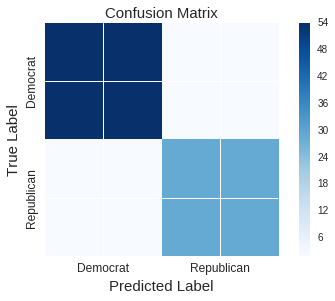

In [48]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Normalized Confusion Matrix
[[ 0.96  0.04]
 [ 0.06  0.94]]


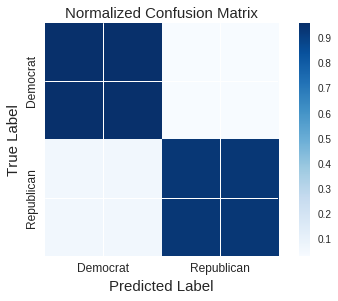

In [44]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

In [45]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[1], tpr[1], _ = roc_curve(y_test, y_pred_proba_republican)
roc_auc[1] = auc(fpr[1], tpr[1])

In [46]:
# Plot of ROC curve for a specific class
def roc_curve_single_class(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size = 15)
    plt.ylabel('True Positive Rate', size = 15)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title('Receiver Operating Characteristic (ROC)', size = 15)
    plt.legend(loc="lower right")
    plt.savefig('plot_roc_curve')
    plt.show()

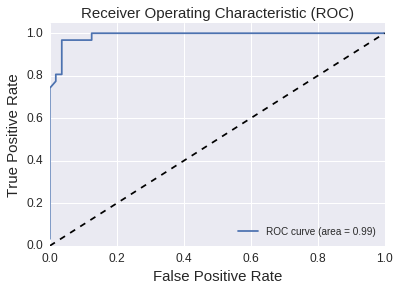

In [47]:
roc_curve_single_class(fpr, tpr, roc_auc)